In [116]:
#Importhing the necessary libraries
import h5py
from sklearn.metrics.pairwise import cosine_similarity
from operator import itemgetter
from scipy.spatial import distance
import numpy as np
import torch
import time
from sklearn.utils import shuffle
import random

In [3]:
#Loading the processed movies metadata 
hf = h5py.File("/content/drive/MyDrive/Colab Notebooks/ee541/Project/movies_data.hd5",'r')
keys = hf.keys()
keys

<KeysViewHDF5 ['id', 'metadata', 'title']>

In [4]:
metadata = hf['metadata'][:]
title = hf['title'][:]
id = hf['id'][:]

In [5]:
metadata = torch.from_numpy(metadata)

In [6]:
w = np.zeros((1,409))

In [7]:
w[0][0] = 1
w[0][1] = 1
w[0][2] = 1
#0.01 + 0.3 + 0.2 + 0.05 +0.01 + 0.2 + 0.2 + 0.03
for i in range(3,103):
  w[0][i] = 15
for i in range(103,203):
  w[0][i] = 6
w[0][203] = 1
w[0][204] = 1
w[0][205] = 1
for i in range(206,306):
  w[0][i] = 3
for i in range(306,406):
  w[0][i] = 3
w[0][407] = 1
w[0][408] = 10

In [8]:
w = torch.from_numpy(w)

In [17]:
cs_matrix = np.ones((6716,6716))

In [30]:
#Generate Cosine Similarity matrix
for i in range(6716):
  movie = metadata[i].reshape((1,409))
  for j in range(6716):
    compare_with_movie = metadata[j].reshape((1,409))
    if(i < j):
      cs_matrix[i][j] = distance.cosine(movie,compare_with_movie, w)
    else:
      if(i!=j):
        cs_matrix[i][j] = cs_matrix[j][i]


In [57]:
#storing the similarity matrix
with h5py.File("cosine_similarities.hd5", 'w') as hf: 
  hf.create_dataset('cosine_distance', data=cs_matrix)

In [112]:
#Initialising data vectors
X_DATA = np.zeros((500000,1227))
Y_LABEL = np.zeros((500000,409))
COMBINED_ID = np.zeros((500000,3))

In [113]:
#List to make random choices from
numbers = [i for i in range(6716)]
indices_list = shuffle(numbers)

In [114]:
#Generating inputs and ylabels
for i in range(500000):
  #select 3 indices at random without replacement
  j,k,l = random.sample(indices_list,3)

  #find the index of the most similar movie
  movie_1_ind = np.argmin(cs_matrix[j])
  movie_2_ind = np.argmin(cs_matrix[k])
  movie_3_ind = np.argmin(cs_matrix[l])

  #Get the vector of these movies
  y = (metadata[movie_1_ind]+metadata[movie_2_ind]+metadata[movie_3_ind])*(1/3)

  #cat those vectors
  x = torch.cat((metadata[j],metadata[k],metadata[l]),0)

  #assign to arrays
  X_DATA[i] = x
  Y_LABEL[i] = y
  COMBINED_ID[i] = np.array([id[movie_1_ind],id[movie_2_ind],id[movie_3_ind]])


In [115]:
#Writing to a h5 file
with h5py.File("generated_data_5k.hd5", 'w') as hf: 
  hf.create_dataset('x_data', data=X_DATA)
  hf.create_dataset('y_label', data=Y_LABEL)
  hf.create_dataset('combination', data=COMBINED_ID)

In [ ]:
score = np.zeros((2,6716))
r= 0 
t = []
for j in range(0,100):
  Y = (1/3)*(metadata[11947]+metadata[11512]+metadata[16539])
  score = np.zeros((1,28725))
  inp = Y.reshape((409,1))
  st = time.time()
  for i in range(28725):
    # if( (i != ids[0]) and (i != ids[1]) and (i != ids[2])):
    y = metadata[i].reshape((409,1))
    cs = distance.cosine(inp.T,y.T, w)
    score[0][i] = cs
  et = time.time()
  t.append(et-st)
# sorted_score = dict(sorted(score.items(), key = itemgetter(1), reverse = False)[:5])

(array([49., 12., 17.,  9.,  1.,  2.,  3.,  2.,  3.,  2.]),
 array([2.38343239, 2.57034981, 2.75726724, 2.94418466, 3.13110209,
        3.31801951, 3.50493693, 3.69185436, 3.87877178, 4.06568921,
        4.25260663]),
 <a list of 10 Patch objects>)

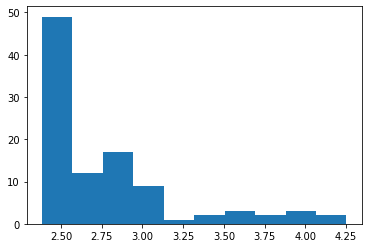

In [ ]:
import matplotlib.pyplot as plt
plt.hist(t)

In [ ]:
def generate_output(i,j,k):
  print("Movie 1: ", str(title[i])[2:-1],'\n')
  print("Movie 2: ", str(title[j])[2:-1],'\n')
  print("Movie 3: ", str(title[k])[2:-1],'\n')
  x = (1/3)*(metadata[i]+metadata[j]+metadata[k])
  print("****** RECOMMENDED MOVIES ******")
  recommendation = similarity(x, [i,j,k])
  # for i in recommendation:
  #   print(i,recommendation[i][1],"\n")
  

In [ ]:
generate_output(5308, 4173, 11947)

Movie 1:  The Italian Job 

Movie 2:  Ocean's Eleven 

Movie 3:  Inception 

****** RECOMMENDED MOVIES ******
Time taken =  3.6085238456726074
The Dark Knight Rises 13641 

Rolling Thunder 6334 

The Long Good Friday 4377 

Faster 12480 

Armed and Dangerous 2030 

